In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor


In [2]:
data = pd.read_csv("../../../data/WellHeader_Datathon.csv")

/Users/alejocoy/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (24,26,27,28,52,54,55,56,80,81) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Clean data functions

In [3]:
def clean_pipeline(df,column_selection=None):
    ## Select objects to convert to category type 
    obj_cast_category = ['Province', 'CurrentOperator', 'CurrentOperatorParentName',
   'Licensee', 'LicenseeParentCompanyName', 'CurrentStatus',
   'CurrentStatusStandardised', 'WellType', 'WellTypeStandardised',
   'Formation', 'Field', 'Pool', 'SurveySystem',
   'Surf_Meridian', 'Surf_TownshipRange',
   'Surf_QuarterUnit', 'Surf_Unit', 'Surf_Block', 'Surf_NTSMapSheet',
   'Surf_Series', 'Surf_Area', 'Surf_Sheet', 'Surf_QuarterSection',
   'BH_Location', 'BH_TownshipRange', 'BH_QuarterUnit', 'BH_Unit',
   'BH_Block', 'BH_NTSMapSheet', 'BH_Series', 'BH_Area', 'BH_Sheet',
   'BH_QuarterSection', 'BH_Meridian', 'LaheeClass', 'Confidential',
   'SurfaceOwner', 'OSArea', 'OSDeposit', 'DrillingContractor',
   'WellProfile', 'Country', 'RegulatoryAgency', 'PSACAreaCode',
   'PSACAreaName', 'StatusSource', 'UnitID', 'UnitName', 'UnitFlag',
   'Agent','Surf_LSD','Surf_Section','Surf_Township','Surf_Range','BH_LSD','BH_Section','BH_Township','BH_Range']
    surface_columns=['Surf_LSD','Surf_Section','Surf_Township','Surf_Range','BH_LSD','BH_Section','BH_Township','BH_Range']
    df[surface_columns]=df[surface_columns].astype(str)
    df[obj_cast_category] = df[obj_cast_category].astype('category')
    
    df_s = df[column_selection]
    df_s['TVD']= df['TVD']
    return df_s

def feature_eng(df):
    y = df['TVD']
    df.drop(columns='TVD',inplace=True)
    #Categorical Values
    cat_attributes =list(df.dtypes[df.dtypes != 'float64'][df.dtypes != 'int64'].index)
    #Numerical Values
    num_attributes=list(set(list(df.columns))-  set (cat_attributes))
    df_num = df.drop(columns=cat_attributes)
    df_cat = df.drop(columns=num_attributes)

    #Replace missing values for Project Depth with median
    imputer = SimpleImputer(strategy='median')
    imputer.fit(df[['ProjectedDepth']])
    df['ProjectedDepth']=imputer.transform(df[['ProjectedDepth']])

    #One hot encoder for categories
    ohe = OneHotEncoder(sparse=False)
    df_ohe = ohe.fit_transform(df_cat)
    columns_names= ohe.get_feature_names(cat_attributes)
    df_cat = pd.DataFrame(df_ohe,columns=columns_names)

    #Numerical pipeline, change normalize numerical values
    num_pipline = Pipeline([
        ('immputer', SimpleImputer(strategy='median')),
        ('std_scales',StandardScaler())
    ])
    # pipeline for numberical 
    df_num1 =num_pipline.fit_transform(df_num)

    #Join numerical and categorical dataframe
    num = pd.DataFrame(df_num1,columns=df_num.columns)
    pd_clean = pd.concat([num,df_cat],axis=1)
    return pd_clean,y

# Create Train and Test set

In [4]:
feature_selection = ['EPAssetsId','Surf_LSD','Surf_Section','Surf_Township','Surf_Range','Surf_Meridian','Surf_Longitude','Surf_Latitude','BH_Longitude','BH_Latitude','GroundElevation',
                    'KBElevation','TotalDepth','Formation','WellType','BH_LSD','BH_Section','BH_Township','BH_Range','WellProfile','ProjectedDepth']
well_header =  clean_pipeline(data,feature_selection)
wh =well_header[~well_header.TVD.isna()]

/Users/alejocoy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
wh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6731 entries, 1 to 10436
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   EPAssetsId       6731 non-null   int64   
 1   Surf_LSD         6731 non-null   category
 2   Surf_Section     6731 non-null   category
 3   Surf_Township    6731 non-null   category
 4   Surf_Range       6731 non-null   category
 5   Surf_Meridian    6731 non-null   category
 6   Surf_Longitude   6731 non-null   float64 
 7   Surf_Latitude    6731 non-null   float64 
 8   BH_Longitude     6731 non-null   float64 
 9   BH_Latitude      6731 non-null   float64 
 10  GroundElevation  6731 non-null   float64 
 11  KBElevation      6731 non-null   float64 
 12  TotalDepth       6731 non-null   float64 
 13  Formation        6731 non-null   category
 14  WellType         6731 non-null   category
 15  BH_LSD           6731 non-null   category
 16  BH_Section       6731 non-null   category

In [6]:
train_df, train_y=feature_eng(wh) 

/Users/alejocoy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/alejocoy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
test_data = pd.read_csv("../../../data/Submission_Sample.csv")

In [8]:
test = well_header[well_header['EPAssetsId'].isin(test_data['EPAssetsId'])].drop(columns='TVD')
test = pd.merge(test,test_data, on='EPAssetsId')
test.to_csv('test1.csv',index=False)

In [9]:
test_df,test_y = feature_eng(test)

In [10]:
final_train, final_test = train_df.align(test_df, join='inner', axis=1,fill_value=0)

In [11]:
final_train.shape,final_test.shape

((6731, 292), (1963, 292))

ML Models

In [12]:
lin_reg = LinearRegression()
lin_reg.fit(final_train,train_y)
pred= lin_reg.predict(final_test)
lin_mse = mean_squared_error(test_y,pred)
linrmse=np.sqrt(lin_mse)
linrmse

1525092545320.1345

In [13]:
rf_reg = RandomForestRegressor()
rf_reg.fit(final_train,train_y)
pred_rf= rf_reg.predict(final_test)
rf_mse = mean_squared_error(test_y,pred_rf)
rfrmse=np.sqrt(rf_mse)
rfrmse

1268.1827125669765

<BarContainer object of 10 artists>

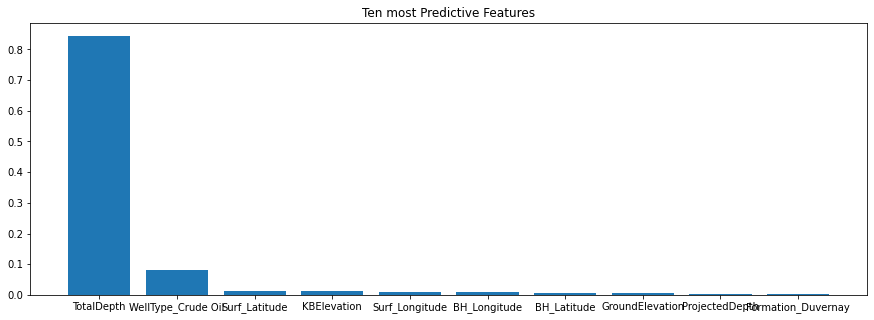

In [14]:
feature_importance=rf_reg.feature_importances_
importances=pd.DataFrame(final_train.columns,feature_importance,columns=['Feature']).reset_index()
importances.columns = ['weight','Feature']
importances = importances.sort_values(['weight'],ascending=False)
imp_plot = importances.iloc[:10]
imp_feature = importances['Feature']
fig = plt.figure(figsize=(15,5))
plt.title('Ten most Predictive Features')
plt.bar(imp_plot['Feature'],imp_plot['weight'])

In [18]:
feature_importance=list(imp_feature[0:10])

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

In [116]:
params = {'n_estimators': 100, # change to 4000 to achieve LB 0.511 - it runs too long in the kaggle kernel mode
        'max_depth': 3,
        'min_samples_split': 10, 
        'min_samples_leaf': 10,
        'learning_rate': 0.001,
        'max_features': 15,
        'subsample': 0.8,
        'loss': 'ls'}
gbr = GradientBoostingRegressor(**params)

In [117]:
gbr.fit(final_train,train_y)
pred_gbr= gbr.predict(final_test)
gbr_mse = mean_squared_error(test_y,pred_gbr)
gbrrmse=np.sqrt(gbr_mse)
gbrrmse

712.8544169706204

In [21]:
from sklearn.model_selection import GridSearchCV
param_grid =[
    {'n_estimators':[500,1000,2000],'max_features': [2,5,9,25],'min_samples_split': [50,100,200,500] },
    ]
gbr1=GradientBoostingRegressor()
grid_search = GridSearchCV(gbr1,param_grid,cv=5, scoring="neg_root_mean_squared_error"
                          ,return_train_score=True)
grid_search.fit(final_train, train_y)



GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid=[{'max_features': [2, 5, 9, 25],
                          'min_samples_split': [50, 100, 200, 500],
                          'n_estimators': [500, 1000, 2000]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [22]:
grid_search.best_params_

{'max_features': 25, 'min_samples_split': 200, 'n_estimators': 2000}

In [33]:
grid_search.best_estimator_

GradientBoostingRegressor(max_features=25, min_samples_split=200,
                          n_estimators=2000)

In [27]:
cvres= grid_search.cv_results_

In [28]:
for mean_score,params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score),params)

13.6543836970692 {'max_features': 2, 'min_samples_split': 50, 'n_estimators': 500}
12.582971417262188 {'max_features': 2, 'min_samples_split': 50, 'n_estimators': 1000}
11.835185877079606 {'max_features': 2, 'min_samples_split': 50, 'n_estimators': 2000}
13.174284646007482 {'max_features': 2, 'min_samples_split': 100, 'n_estimators': 500}
12.503117572525676 {'max_features': 2, 'min_samples_split': 100, 'n_estimators': 1000}
11.808726458431758 {'max_features': 2, 'min_samples_split': 100, 'n_estimators': 2000}
13.496317590712104 {'max_features': 2, 'min_samples_split': 200, 'n_estimators': 500}
12.401326937862022 {'max_features': 2, 'min_samples_split': 200, 'n_estimators': 1000}
11.668234490829057 {'max_features': 2, 'min_samples_split': 200, 'n_estimators': 2000}
13.605066789934336 {'max_features': 2, 'min_samples_split': 500, 'n_estimators': 500}
12.793541109542433 {'max_features': 2, 'min_samples_split': 500, 'n_estimators': 1000}
11.54029155367702 {'max_features': 2, 'min_samples_s

In [203]:
# Create submission file
sub = pd.DataFrame()
sub['EPAssetId'] = test['EPAssetsId']
sub['TVD'] = pred_rf 
sub.to_csv('tvd_conqueros.csv', float_format='%.6f', index=False)